In [119]:
import time
import os
import seaborn as sns
import numpy as np
import pandas as pd
import sys
%load_ext autoreload
%autoreload 2
import logging
# from toolsets.spectra_operations import entropy_similarity_default
from toolsets.std_list_prep import complete_adducts, complete_formula, complete_formal_charge, crude_list_cleanup
# from toolsets.API_gets import complete_smiles
from toolsets.search import string_search, num_search
from toolsets.mzml_plot import EIC, TIC
import toolsets.spectra_operations as so
from tqdm import tqdm
from toolsets.features_by_alphapept import find_features_alphapept
import matplotlib.pyplot as plt
import seaborn as sns
source_dir = "/Users/fanzhoukong/Documents/GitHub/Libgen_data/UVPD"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# start curating library for UVPD

In [130]:
# std_list_raw_pos = pd.read_csv(os.path.join(source_dir,"std_list_pos_crude.csv"))
# std_list_raw_neg = pd.read_csv(os.path.join(source_dir,"std_list_neg_crude.csv"))
# std_list_raw_pos = complete_formula(std_list_raw_pos,'smiles_fetched')
# std_list_raw_neg = complete_formula(std_list_raw_neg,'smiles_fetched')
# std_list_raw_pos=complete_formal_charge(std_list_raw_pos,'smiles_fetched')
# std_list_raw_neg=complete_formal_charge(std_list_raw_neg,'smiles_fetched')
# from toolsets.std_list_prep import neutrilize_salt_df
# std_list_pos = neutrilize_salt_df(std_list_raw_pos, '[Na+,K+,Cl-,HCl]')
# std_list_neg = neutrilize_salt_df(std_list_raw_neg, '[Na+,K+,Cl-,HCl]')
# std_list_pos=crude_list_cleanup(std_list_pos, adducts=['[M]+','[M+H]+', '[M+Na]+', '[M+NH4]+', '[M-H2O+H]+'])
# std_list_neg=crude_list_cleanup(std_list_neg, adducts=['[M]-','[M-H]-','[M+C2H4O2-H]-','[M-H2O-H]-','[M+Cl]-'])
# std_list_pos.to_csv(os.path.join(source_dir, 'std_list_pos_ready.csv'), index =  False)
# std_list_neg.to_csv(os.path.join(source_dir, 'std_list_neg_ready.csv'), index =  False)

# Curating library in UVPD

In [58]:
feature_folder = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/UVPD/Features'
std_list_pos = pd.read_csv(os.path.join(source_dir, 'std_list_pos_ready.csv'))
std_list_neg = pd.read_csv(os.path.join(source_dir, 'std_list_neg_ready.csv'))
from toolsets.precursor_matching import precursor_matching_global
matched_hcd_pos = precursor_matching_global(std_list_pos, os.path.join(feature_folder, 'HCD_pos_MS2'), adducts = ['[M]+','[M+H]+', '[M+Na]+', '[M+NH4]+', '[M-H2O+H]+'],step=10, ppm = True, comment='HCD_pos')
matched_hcd_neg = precursor_matching_global(std_list_neg, os.path.join(feature_folder, 'HCD_neg_MS2'), adducts = ['[M]-','[M-H]-','[M+C2H4O2-H]-','[M-H2O-H]-','[M+Cl]-'],step=10, ppm = True,comment='HCD_neg')
matched_uvpd_pos = precursor_matching_global(std_list_pos, os.path.join(feature_folder, 'UVPD_pos_MS2'), adducts = ['[M]+','[M+H]+', '[M+Na]+', '[M+NH4]+', '[M-H2O+H]+'],step=10, ppm = True,comment='UVPD_pos')
matched_uvpd_neg = precursor_matching_global(std_list_neg, os.path.join(feature_folder, 'UVPD_neg_MS2'), adducts = ['[M]-','[M-H]-','[M+C2H4O2-H]-','[M-H2O-H]-','[M+Cl]-'],step=10, ppm = True,comment='UVPD_neg')
from toolsets.spectra_operations import normalized_entropy, pack_spectra, spectral_entropy
from toolsets.deduplication import match_by_rt
matched_mapped, matched_unmapped , matched_not_found= match_by_rt([matched_hcd_pos,matched_hcd_neg,matched_uvpd_pos,matched_uvpd_neg])

cleaning spectrum...


100%|██████████| 4614/4614 [00:30<00:00, 150.43it/s]


cleaning spectrum...


100%|██████████| 4983/4983 [00:30<00:00, 164.62it/s]


cleaning spectrum...


100%|██████████| 4513/4513 [00:43<00:00, 102.80it/s]


cleaning spectrum...


100%|██████████| 4905/4905 [00:21<00:00, 224.92it/s]


finding seed...


100%|██████████| 1619/1619 [00:07<00:00, 229.42it/s]


making matches


100%|██████████| 1617/1617 [00:03<00:00, 506.38it/s]


In [60]:
matched_mapped['comment'].value_counts()

HCD_neg     1823
HCD_pos     1821
UVPD_pos    1778
UVPD_neg    1778
Name: comment, dtype: int64

In [146]:
from toolsets.helpers import save_value_counts
vc = save_value_counts(matched_mapped, 'comment')


from toolsets.mass_recalibration import data_recalibrate
data_all = {}
for comment in vc['unique_values'].unique():
    data_all[comment]=string_search(matched_mapped, 'comment',comment)
    data_all[comment].reset_index(inplace=True, bdrop=True)
    data_all[comment]=data_recalibrate(data_all[comment])
# for filename in data_all.keys():
#     data_all[filename].to_csv(os.path.join(source_dir, filename+'_mapped_raw.csv'), index = False)
from toolsets.spectra_operations import weighted_average_spectra

# data_all['HCD_neg']

100%|██████████| 59/59 [00:00<00:00, 220.68it/s]


In [147]:
test = data_all['UVPD_pos']

In [148]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

In [149]:
x_temp = test['precursor_mz'].values
y_temp =  test['reference_precursor_mz'].values

In [152]:
y_pred = regr.predict(x_temp.reshape(-1,1))

# drawing figures for deduplication

In [76]:
from toolsets.spectra_plotter import ms2_plot
import toolsets.spectra_operations as so
import matplotlib as plt
figure_dir = '/Users/fanzhoukong/Library/CloudStorage/OneDrive-Personal/Desktop/UCDAVIS_Phd/Libgen/manuscript/figures'

In [158]:
matched_mapped_uvpd_pos = string_search(matched_mapped, 'comment','UVPD_pos')
key_dup = []
for key in matched_mapped_uvpd_pos['key'].unique():
    data_temp = string_search(matched_mapped_uvpd_pos,'key', key)
    if len(data_temp)>3:
        key_dup.append(key)

In [112]:
from toolsets.spectra_plotter import ms_figure_simple

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


In [159]:
data_temp = string_search(matched_mapped_uvpd_pos, 'key', key_dup[1])

In [160]:
wa= so.weighted_average_spectra(data_temp)

In [165]:
from toolsets.spectra_operations import entropy_similarity_default

In [171]:
msms1 = pack_spectra([100, 105, 171,182, 291],[10, 30, 20, 100, 5])

In [172]:
msms2 = pack_spectra([100, 105, 171,182, 291],[0,0 , 15, 100, 3])

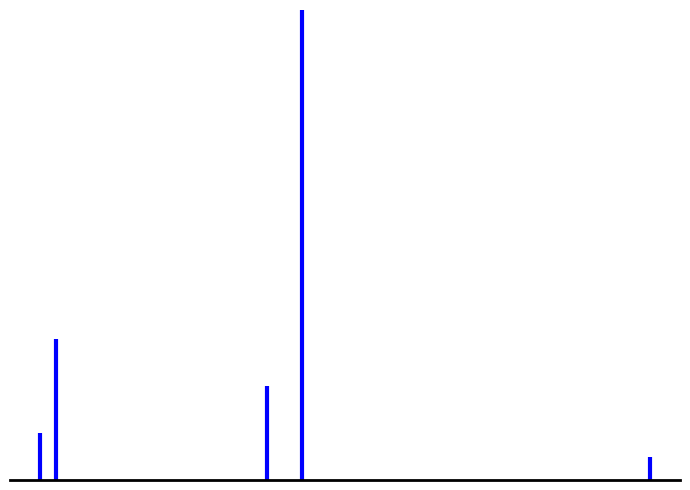

In [175]:
ms_figure_simple(msms1,
                 savepath=os.path.join(figure_dir, 'matching_up_virtual.tiff'),
                 color = 'blue')

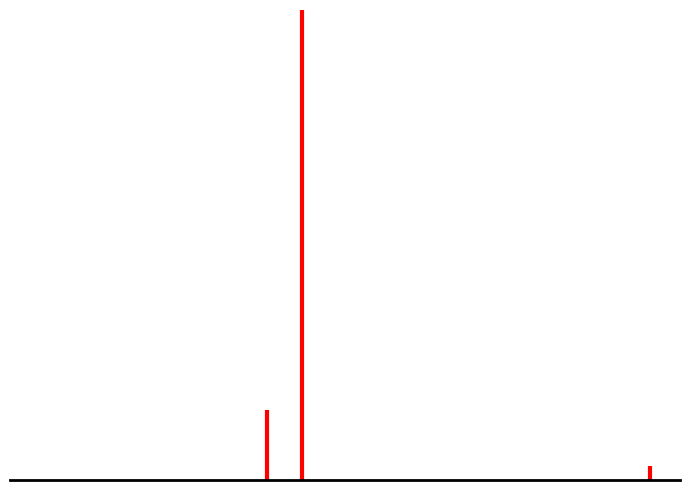

In [174]:
ms_figure_simple(msms2,
                 savepath=os.path.join(figure_dir, 'matching_down_virtual.tiff'),
                 color = 'red')

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


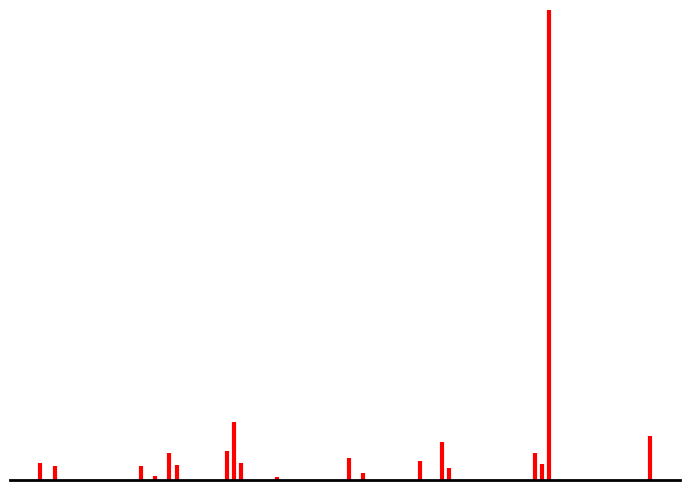

In [169]:
ms_figure_simple(wa,
                 savepath=os.path.join(figure_dir, 'matching_down.tiff'),
                 color = 'red')

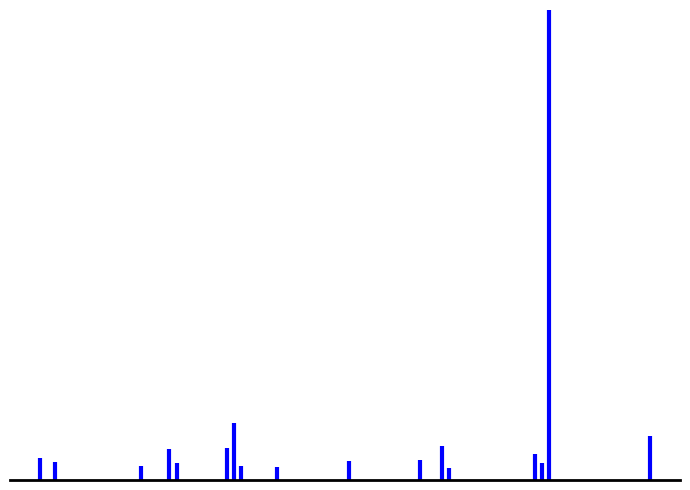

In [170]:
ms_figure_simple(data_temp.iloc[1]['peaks'],
                 savepath=os.path.join(figure_dir, 'matching_up.tiff'),
                 color = 'blue')

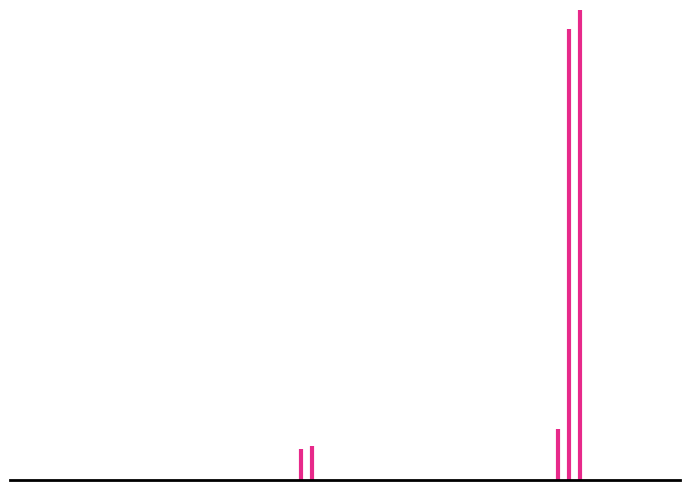

In [122]:
ms_figure_simple(data_temp.iloc[3]['peaks'], savepath=os.path.join(figure_dir, 'denoising4.tiff'), color = sns.color_palette("Dark2")[3])

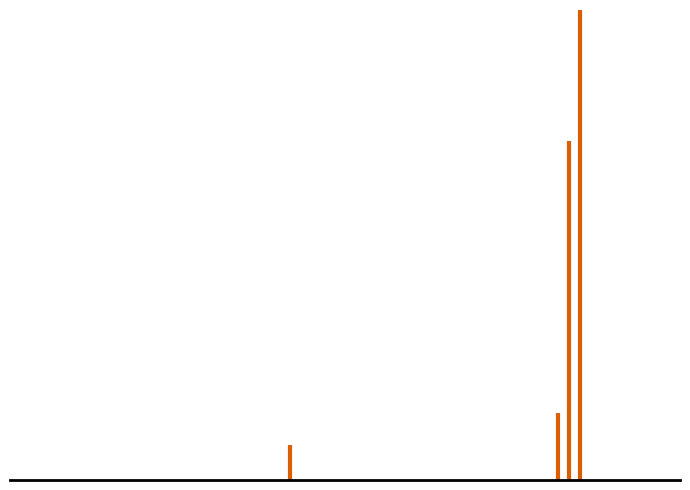

In [110]:
msms1 = (data_temp.iloc[0]['peaks'])
mass, intensity =so.break_spectra(msms1)
d = {'m/z':mass, 'intensity':intensity}
msms1 = pd.DataFrame(d)
max_val = np.max(msms1['intensity'])
msms1["normalized_intensity"] = msms1['intensity'] / max_val * 100.0  # normalize intensity to percent
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (7, 5),facecolor="white")
# fig.figure()
plt.subplots_adjust()
ax = fig.subplots()
for i in range(len(msms1['m/z'])):
    plt.vlines(x = msms1["m/z"][i], ymin = 0, ymax = msms1["normalized_intensity"][i],color = sns.color_palette("Dark2")[1], linewidth = 3)
ax.set_xlim(150, 210)
ax.set_ylim(0, 100)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set(color = 'black', linewidth = 2)
ax.spines['left'].set_visible(False)
fig.tight_layout()
ax.grid(False)
plt.savefig(os.path.join(figure_dir, 'denoising_1.tiff'), dpi = 300,transparent=True, edge_color = 'none')

# end of deduplication figuring

In [41]:
from toolsets.helpers import save_value_counts
vc = save_value_counts(matched_mapped, 'comment')


from toolsets.mass_recalibration import data_recalibrate
data_all = {}
for comment in vc['unique_values'].unique():
    data_all[comment]=string_search(matched_mapped, 'comment',comment)
    data_all[comment].reset_index(inplace=True, drop=True)
    data_all[comment]=data_recalibrate(data_all[comment])
for filename in data_all.keys():
    data_all[filename].to_csv(os.path.join(source_dir, filename+'_mapped_raw.csv'), index = False)
from toolsets.spectra_operations import weighted_average_spectra

data_all['HCD_neg']

100%|██████████| 59/59 [00:00<00:00, 223.04it/s]


In [33]:
for method in data_all.keys():
    wa_spctra = []
    wa_rts = []
    data_temp = data_all[method]
    for key in tqdm(data_temp['key'].unique()):
        adduct_temp = string_search(data_temp,'key',key)
        wa_spctrum = weighted_average_spectra(adduct_temp,typeofmsms = 'peaks_recalibrated')
        wa_rt =(adduct_temp['retention_time']*adduct_temp['ms1_precursor_intensity']/adduct_temp['ms1_precursor_intensity'].sum()).sum()
        wa_spctra.extend([wa_spctrum]*len(adduct_temp))
        wa_rts.extend([wa_rt]*len(adduct_temp))
    data_all[method]['peaks_recalibrated_wa']=wa_spctra
    data_all[method]['retention_time_wa']=wa_rts
    data_all[method].sort_values(by = ['key','ms1_precursor_intensity'], ascending=False, inplace=True)
    data_all[method].drop_duplicates('key', keep='first', inplace=True)
    data_all[method].reset_index(inplace=True, drop=True)
data_enlongated = pd.DataFrame()
for method in data_all.keys():
    data_temp = data_all[method]
    data_enlongated = data_enlongated.append(data_temp)

NameError: name 'data_all' is not defined

In [49]:
from toolsets.helpers import get_df_name

In [52]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [46]:
data_enlongated.to_csv(os.path.join(source_dir, 'data_enlongated_ready_for_denoising_new.csv'), index = False)

# end for other processing; will run denoising algorithm separately

In [108]:
data_enlongated = pd.read_csv(os.path.join(source_dir, 'data_enlongated_ready_for_denoising_new_denoised.csv'))
data_enlongated['c_id']=np.arange(len(data_enlongated))

In [109]:
from toolsets.denoising_related_functions import post_processing

In [110]:
data_all = {}
for method in data_enlongated['comment'].unique():
    data_all[method]= string_search(data_enlongated, 'comment', method)
    # data_all[method]= data_all[method].drop(['Unnamed: 0'], axis=1)

In [111]:
data_uvpd = pd.concat([data_all['UVPD_neg'], data_all['UVPD_pos']], axis=0, ignore_index=True)
data_hcd = pd.concat([data_all['HCD_neg'], data_all['HCD_pos']], axis=0, ignore_index=True)

In [134]:
data_uvpd_good = post_processing(data_uvpd, high_quality=True)
data_uvpd_bad = post_processing(data_uvpd, high_quality=False)

In [135]:
data_hcd_good = post_processing(data_hcd, high_quality=True)
data_hcd_bad = post_processing(data_hcd, high_quality=False)

In [42]:
from toolsets.spectra_operations import normalized_entropy

In [136]:
normalized_raw = []
for index, row in data_uvpd_bad.iterrows():
    normalized_raw.append(so.normalized_entropy(row['peaks_recalibrated_wa']))
data_uvpd_bad['normalized_entropy_raw']=normalized_raw
normalized_raw = []
for index, row in data_uvpd_good.iterrows():
    normalized_raw.append(so.normalized_entropy(row['peaks_recalibrated_wa']))
data_uvpd_good['normalized_entropy_raw']=normalized_raw
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
# ax= sns.histplot(data=data_UVPD, x="normalized_entropy", multiple="stack", kde = True, palette="red")
# ax = sns.histplot(data=data_HCD, x="normalized_entropy", multiple="stack", kde = True,color="green")
ax=sns.histplot(data=data_uvpd_good, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette()[2], alpha = 0.3,stat='probability',kde=True)
ax=sns.histplot(data=data_uvpd_bad, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette()[3], alpha = 0.3,stat='probability',kde=True)
plt.axvline(0.8, 0, color = 'red' )
# ax=sns.histplot(data=data_uvpd_good, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette("Set2")[0], stat='probability')
# ax=sns.histplot(data=data_uvpd_bad, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette("Set2")[1],stat='probability')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Normalized entropy", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(labels=["High-quality spectra","Low-quality spectra"], loc = 'upper left',fontsize=12)
plt.savefig(os.path.join(source_dir,'normalized_entropy_UVPD_high_low_quality.tiff'), dpi = 300,transparency = True,facecolor = 'white', edgecolor = 'white')

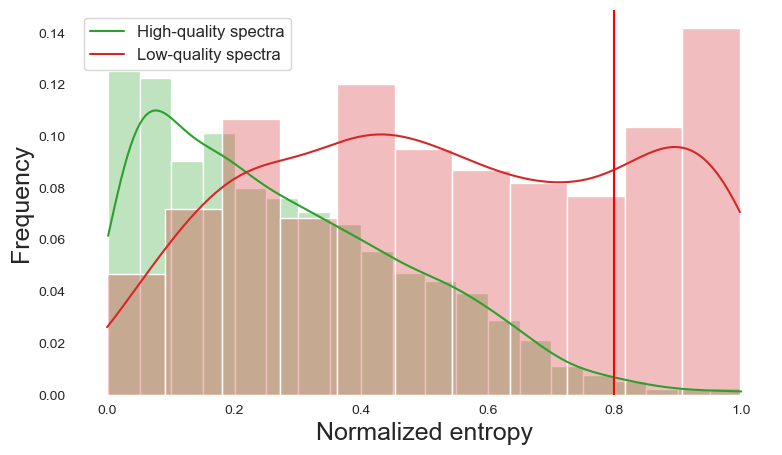

In [142]:
normalized_raw = []
for index, row in data_hcd_bad.iterrows():
    normalized_raw.append(so.normalized_entropy(row['peaks_recalibrated_wa']))
data_hcd_bad['normalized_entropy_raw']=normalized_raw
normalized_raw = []
for index, row in data_hcd_good.iterrows():
    normalized_raw.append(so.normalized_entropy(row['peaks_recalibrated_wa']))
data_hcd_good['normalized_entropy_raw']=normalized_raw
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
# ax= sns.histplot(data=data_UVPD, x="normalized_entropy", multiple="stack", kde = True, palette="red")
# ax = sns.histplot(data=data_HCD, x="normalized_entropy", multiple="stack", kde = True,color="green")
ax=sns.histplot(data=data_hcd_good, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette()[2], alpha = 0.3,stat='probability',kde=True)
ax=sns.histplot(data=data_hcd_bad, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette()[3], alpha = 0.3,stat='probability',kde=True)
plt.axvline(0.8, 0, color = 'red' )
# ax=sns.histplot(data=data_uvpd_good, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette("Set2")[0], stat='probability')
# ax=sns.histplot(data=data_uvpd_bad, x='normalized_entropy_raw', multiple="stack",color = sns.color_palette("Set2")[1],stat='probability')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Normalized entropy", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(labels=["High-quality spectra","Low-quality spectra"], loc = 'upper left',fontsize=12)
# plt.savefig(os.path.join(source_dir,'normalized_entropy_UVPD_high_low_quality.tiff'), dpi = 300,transparency = True,facecolor = 'white', edgecolor = 'white')

In [144]:
data_uvpd_good.to_csv(os.path.join(source_dir, 'UVPD_library.csv'), index = False)
data_hcd_good.to_csv(os.path.join(source_dir, 'HCD_library.csv'), index = False)
from toolsets.file_io import export_library_msp
export_library_msp(data_uvpd_good,os.path.join(source_dir, 'UVPD_library.txt'), typeofmsms='peaks_denoised_normalized')
export_library_msp(data_hcd_good,os.path.join(source_dir, 'HCD_library.txt'), typeofmsms='peaks_denoised_normalized')

100%|██████████| 1947/1947 [00:00<00:00, 3637.36it/s]


# getting chemical classes for library

In [145]:
from toolsets.API_gets import GNPS_classyfire, get_classyfire_data
# GNPS_classyfire(inputt, class_type, input_type ='inchikey')

In [146]:
data_UVPD=pd.read_csv(os.path.join(source_dir, 'UVPD_library.csv'))
data_HCD=pd.read_csv(os.path.join(source_dir, 'HCD_library.csv'))

In [147]:
data_UVPD.shape

(1012, 36)

In [148]:
data_UVPD_classyfire= get_classyfire_data(data_UVPD)

100%|██████████| 1012/1012 [04:50<00:00,  3.48it/s]


In [149]:
data_HCD_classyfire= get_classyfire_data(data_HCD)

100%|██████████| 1947/1947 [09:26<00:00,  3.44it/s]


In [150]:
data_UVPD_classyfire.to_csv(os.path.join(source_dir, 'UVPD_library_cla.csv'), index = False)
data_HCD_classyfire.to_csv(os.path.join(source_dir, 'HCD_library_cla.csv'), index = False)

# statistics for UVPD lib

In [32]:
from toolsets.spectra_operations import clean_spectrum, entropy_similarity_default

In [112]:
entropy_similiary = []

for index, row in data_UVPD.iterrows():
    data_temp = string_search(data_HCD,'key',row['key'])
    if len(data_temp)==1:
        entropy_similiary.append(entropy_similarity_default(row['peaks'], data_temp.iloc[0]['peaks']))
    else:
        entropy_similiary.append(np.NAN)

In [84]:
from toolsets.spectra_operations import spectral_entropy

In [136]:
data_UVPD.shape

(1003, 36)

In [135]:
(data_UVPD[~data_UVPD['HCD_similarity'].isnull()]).shape

(833, 36)

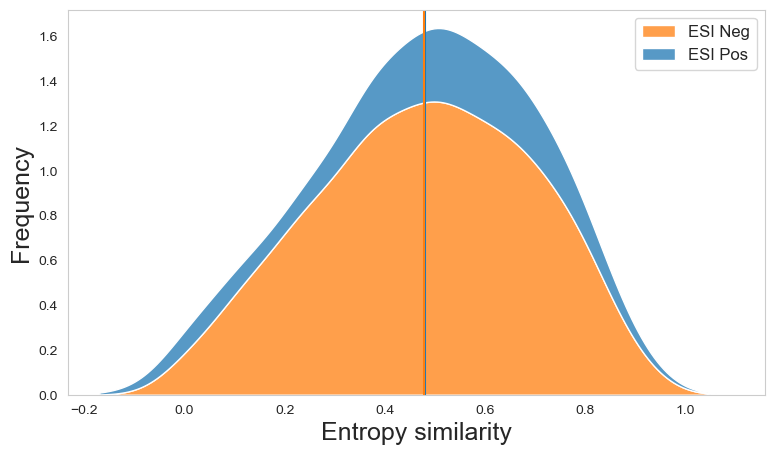

In [138]:
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
sns.kdeplot(data=data_UVPD, x='HCD_similarity',hue="charge", multiple="stack",palette="tab10")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Entropy similarity", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)

plt.axvline(0.481467, 0, color = sns.color_palette("tab10")[0] )
plt.axvline(0.478518, 0, color = sns.color_palette("tab10")[1] )
plt.legend(labels=['ESI Neg','ESI Pos'], loc = 'upper right',fontsize=12)
plt.savefig(os.path.join(source_dir,'entropy_similarity_uvpd_hcd.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [119]:
sns.color_palette("tab10")[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

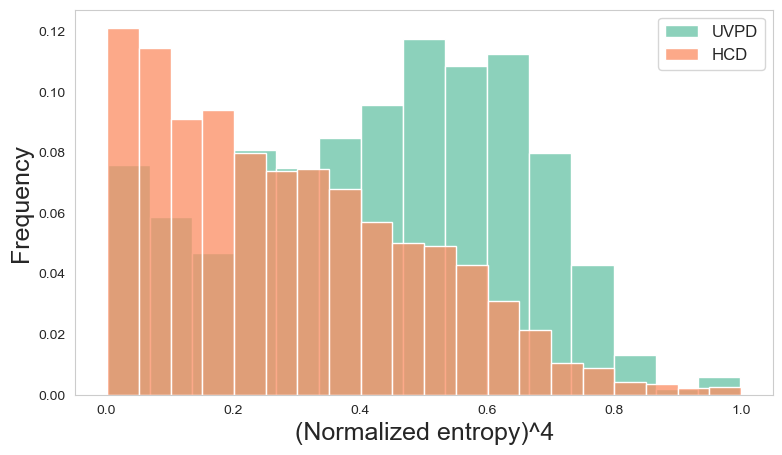

In [137]:
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
# ax= sns.histplot(data=data_UVPD, x="normalized_entropy", multiple="stack", kde = True, palette="red")
# ax = sns.histplot(data=data_HCD, x="normalized_entropy", multiple="stack", kde = True,color="green")
ax=sns.histplot(data=data_UVPD, x='normalized_entropy', multiple="stack",color = sns.color_palette("Set2")[0], stat='probability')
ax=sns.histplot(data=data_HCD, x='normalized_entropy', multiple="stack",color = sns.color_palette("Set2")[1],stat='probability')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("(Normalized entropy)^4", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
plt.legend(labels=["UVPD","HCD"], loc = 'upper right',fontsize=12)
plt.savefig(os.path.join(source_dir,'normalized_entropy_uvpd_hcd.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

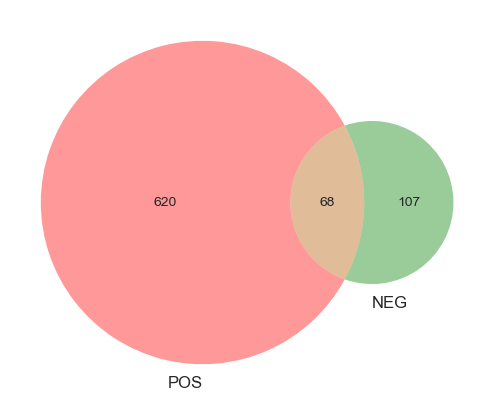

In [142]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted, venn3_circles, venn3, venn2_unweighted, venn2
set1 = set(string_search(data_UVPD,'charge',1)['reference_inchikey'])
set2 = set(string_search(data_UVPD,'charge',-1)['reference_inchikey'])
# set2 = set(string_search(data_good_quality,'reference_adduct','[M+Na]+')['reference_InChIKey'])
# set3 = set(string_search(data_good_quality,'reference_adduct','[M+NH4]+')['reference_InChIKey'])
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
venn2([set1,set2],('POS','NEG'))
# venn3([set1, set2, set3], ('[M+H]+', '[M+Na]+', '[M+NH4]+'))

# plt.show()
plt.savefig(os.path.join(source_dir,'venn_diagram_UVPD_pos_neg.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [144]:
data_UVPD['reference_adduct'].value_counts()

[M+H]+           433
[M-H2O+H]+       135
[M+NH4]+         134
[M-H]-           115
[M+Na]+          103
[M+C2H4O2-H]-     72
[M]+               5
[M+Cl]-            3
[M-H2O-H]-         3
Name: reference_adduct, dtype: int64

In [153]:
import toolsets.helpers as helpers
adduct_results_pos = helpers.save_value_counts(string_search(data_UVPD,'charge',1),'reference_adduct')
adduct_results_neg = helpers.save_value_counts(string_search(data_UVPD,'charge',-1),'reference_adduct')

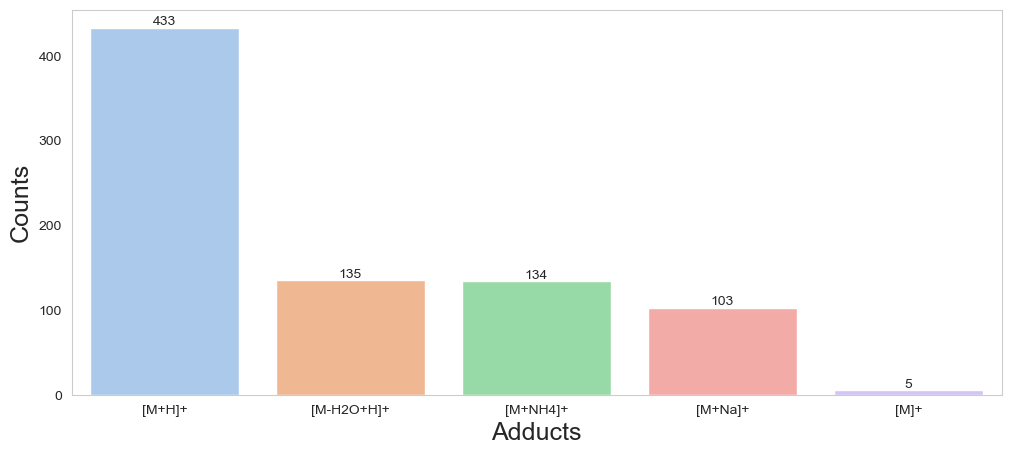

In [170]:
fig, ax = plt.subplots(
    figsize = (12, 5)
                      )
sns.barplot(x = adduct_results_pos['unique_values'], y = adduct_results_pos['counts'], palette = sns.color_palette("pastel"))
ax.set_xlabel("Adducts", fontsize = 18)
ax.set_ylabel("Counts", fontsize = 18)
ax.bar_label(ax.containers[0])
ax.grid(False)
plt.savefig(os.path.join(source_dir,'adducts_distribution_pos.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [157]:
adduct_results_neg

,unique_values,counts
0,[M-H]-,115
1,[M+C2H4O2-H]-,72
2,[M+Cl]-,3
3,[M-H2O-H]-,3


In [159]:
sns.color_palette("muted")[5:]

[(0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [163]:
sns.color_palette("muted")[5]

(0.5490196078431373, 0.3803921568627451, 0.23529411764705882)

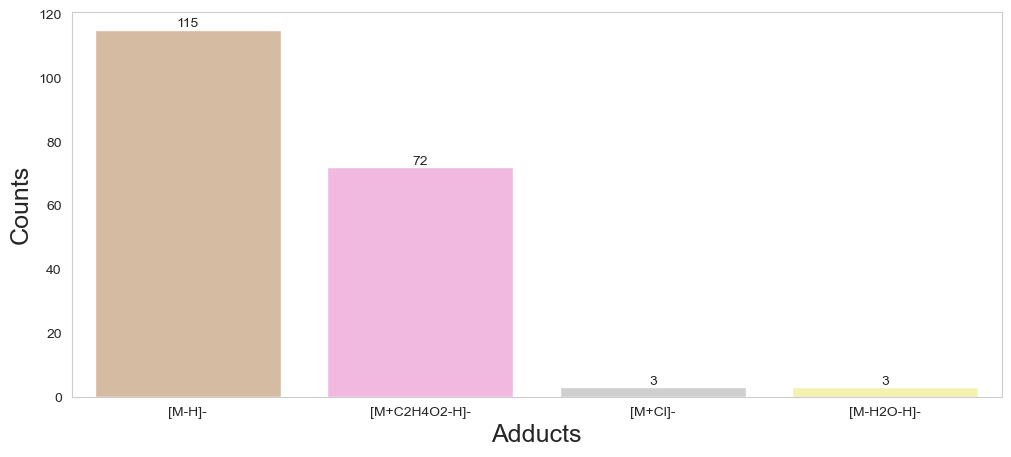

In [171]:
fig, ax = plt.subplots(
    figsize = (12, 5)
                      )
sns.barplot(x = adduct_results_neg['unique_values'], y = adduct_results_neg['counts'], palette= sns.color_palette("pastel")[5:])
ax.set_xlabel("Adducts", fontsize = 18)
ax.set_ylabel("Counts", fontsize = 18)
ax.bar_label(ax.containers[0])
ax.grid(False)
plt.savefig(os.path.join(source_dir,'adducts_distribution_neg.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')